# Chapter: Other Useful Methods

# Topic:  Process Fault Detection via kNN 

In [1]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##         Process Fault Detection via kNN
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [2]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [3]:
# fetch data
import scipy.io

matlab_data = scipy.io.loadmat('MACHINE_Data.mat', struct_as_record = False)
Etch_data = matlab_data['LAMDATA']
calibration_dataAll = Etch_data[0,0].calibration # calibration_dataAll[i,0] corresponds to a 2D data from ith batch where columns correspond to different variables 

variable_names = Etch_data[0,0].variables

In [4]:
# generate unfolded data matrix
n_vars = variable_names.size - 2 # first 2 columns are not process variables
n_samples = 85 # following the work of He et al.

unfolded_dataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(calibration_dataAll.size):
    calibration_expt = calibration_dataAll[expt,0][5:90,2:] # removing first 5 measurements as done in He et al.
    
    if calibration_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(calibration_expt, order='F')[np.newaxis,:]
    unfolded_dataMatrix = np.vstack((unfolded_dataMatrix, unfolded_row))

unfolded_dataMatrix = unfolded_dataMatrix[1:,:]

In [5]:
# scale data & fit PCA model via pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 3))])
score_train = pipe.fit_transform(unfolded_dataMatrix)

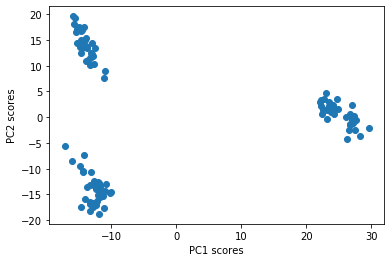

In [6]:
# visualize in 2D
plt.figure()
plt.scatter(score_train[:,0],score_train[:,1])
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.show()

In [7]:
#%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##        k-nearest neighbors of each training sample in score space
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=6).fit(score_train) # a data-point is its own neighbor in training dataset
d2_nbrs, indices = nbrs.kneighbors(score_train)
d2_sqrd_nbrs = d2_nbrs**2
D2 = np.sum(d2_sqrd_nbrs, axis = 1)
D2_log = np.log(D2) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


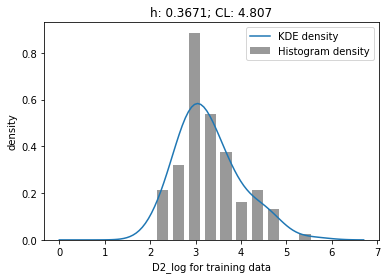

In [8]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##            Compute D2 control limit via KDE
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

def get_CL_via_KDE(metric_values, percentile, metricLabel):
    """ calculate control limit for a monitoring statistic via KDE 
    
    parameters
    -----------
    metric_values: numpy array of shape = [n_samples,]
          
    """
    
    # find optimal KDE bandwidth via CV
    N = len(metric_values)
    empirical_h = 1.06*np.std(metric_values)*N**(1/5)
    h_grid = np.linspace(0,5,50)*empirical_h 
    
    grid = GridSearchCV(KernelDensity(),{'bandwidth': h_grid}, cv=N) # leave-one-out CV
    grid.fit(metric_values[:,None]) # 2D array is expected
    optimal_h = grid.best_params_['bandwidth']
    
    # compute pdf values via KDE 
    kde = grid.best_estimator_  
    metric_grid = np.linspace(0,1.2*np.max(metric_values),100)[:,None]
    metric_pdf_values = np.exp(kde.score_samples(metric_grid))
    
    # Find control limit via numerical integration
    metric_cdf_values = [np.trapz(metric_pdf_values[:i, None], metric_grid[:i,:], axis=0)[0] for i in range(100)]
    metric_CL = metric_grid[np.argmax(np.array(metric_cdf_values) > percentile/100),0]
    
    # KDE plot with histogram
    plt.figure()
    plt.hist(metric_values, bins=10, color='grey', histtype='bar', alpha=0.8, density=True, rwidth=0.7, label='Histogram density')
    plt.plot(metric_grid, metric_pdf_values, alpha=1, label='KDE density')
    plt.title('h: {:.4f}; CL: {:.3f}'.format(optimal_h, metric_CL))
    plt.ylabel('density')
    plt.xlabel(metricLabel)
    plt.legend()
    
    return metric_CL

D2_log_CL = get_CL_via_KDE(D2_log, 95, 'D2_log for training data')

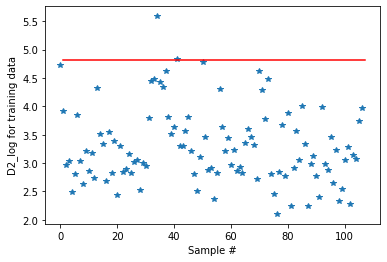

In [9]:
# monitoring chart for training data
plt.figure()
plt.plot(D2_log, '*')
plt.plot([1,len(D2_log)],[D2_log_CL, D2_log_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('D2_log for training data')
plt.show()

In [10]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [11]:
# fetch test data and unfold
test_dataAll = Etch_data[0,0].test

unfolded_TestdataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(test_dataAll.size):
    test_expt = test_dataAll[expt,0][5:90,2:]
    
    if test_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(test_expt, order='F')[np.newaxis,:]
    unfolded_TestdataMatrix = np.vstack((unfolded_TestdataMatrix, unfolded_row))

unfolded_TestdataMatrix = unfolded_TestdataMatrix[1:,:]

In [12]:
# scale and PCA on faulty test data
score_test = pipe.transform(unfolded_TestdataMatrix)

In [13]:
# D2_log_test
d2_nbrs_test, indices = nbrs.kneighbors(score_test)
d2_nbrs_test = d2_nbrs_test[:,0:5] # we want only 5 nearest  neighbors
d2_sqrd_nbrs_test = d2_nbrs_test**2
D2_test = np.sum(d2_sqrd_nbrs_test, axis = 1)
D2_log_test = np.log(D2_test)

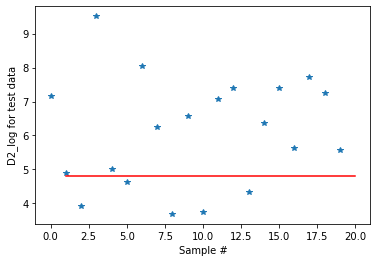

In [14]:
# monitoring chart for test data
plt.figure()
plt.plot(D2_log_test, '*')
plt.plot([1,len(D2_log_test)],[D2_log_CL, D2_log_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('D2_log for test data')
plt.show()